In [42]:
import numpy as np 
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys, os 
sys.path.append(os.path.abspath(os.path.join('../scripts/')))
# Import utility scripts
from data_cleaner import *

In [4]:
util = Clean_Data()

Utility Functions Imported!!!


In [71]:
def get_date_features(df,col):
    df[col] = pd.to_datetime(df[col])
    df['Year'] = df[col].dt.year
    df['Month'] = df[col].dt.month
    df['Day'] = df[col].dt.day
    df['WeekOfYear'] = df[col].dt.weekofyear
#     df.drop(columns=[col], axis=1,inplace=True)

In [6]:
store_db = util.read_data('../data/store.csv')
train_db = util.read_data('../data/train.csv')

In [7]:
db = pd.merge(left=train_db,right=store_db,on='Store',how='inner')

In [85]:
db.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [73]:
db.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [95]:
# Process data for dashboard
train = db[(db.Open != 0) & (db.Sales>0)]
def process(df):
    
    #Replacing null values for CompetitionOpenSinceMonth,CompetitionOpenSinceYear
    util.fill_null('CompetitionOpenSinceMonth',df,df['CompetitionOpenSinceMonth'].mean())
    util.fill_null('CompetitionOpenSinceYear',df,df['CompetitionOpenSinceYear'].mean())
    util.fill_null('CompetitionDistance',df,df['CompetitionDistance'].mean())
    df.fillna(0, inplace=True)
    
    #label encode categorical_features  
    mapping = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    df.StoreType.replace(mapping, inplace=True)
    df.Assortment.replace(mapping, inplace=True)
    
    df['IsHoliday'] = df.StateHoliday.map({'0':0,'a':1,'b':1,'c':1,0:0})
    df['IsWeekend'] = df.DayOfWeek.map({6:1,7:1,1:0,2:0,3:0,4:0,5:0})
    
    #Get date features  
    get_date_features(df, 'Date')
    
    #Calculate competitor open time in months
    df['CompetitionOpenMonths'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + \
    (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpenMonths'] = df['CompetitionOpenMonths'].apply(lambda x: x if x > 0 else 0)

    # calculate promo2 open time in months
    df['Promo2OpenMonths'] = 12 * (df.Year - df.Promo2SinceYear) + \
        (df.WeekOfYear - df.Promo2SinceWeek) / 4.0
    df['Promo2OpenMonths'] = df['Promo2OpenMonths'].apply(lambda x: x if x > 0 else 0)
    
    #Check if month in promo2 month
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    df['month_str'] = df.Month.map(month2str)
    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    df['IsPromoMonth'] =  df.apply(lambda row: check(row),axis=1)  
    # select the features we need
    features = ['Store', 'DayOfWeek', 'Promo', 'IsHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpenMonths', 'Promo2OpenMonths', 'IsPromoMonth','IsWeekend']
    X = df[features]
    y = df[['Sales']]
    feature = df[features]
    target = df[['Sales','Date']]
    feature.reset_index().drop(columns=['index'], inplace =True)
    feature.to_csv('../Data/X.csv')
    target.reset_index().drop(columns=['index'], inplace =True)
    target.to_csv('../Data/Y.csv')
    return X,y
    
X,y = process(train)


In [87]:
X.isna().sum()

Store                        0
DayOfWeek                    0
Promo                        0
IsHoliday                    0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
CompetitionOpenMonths        0
Promo2OpenMonths             0
IsPromoMonth                 0
IsWeekend                    0
dtype: int64

In [90]:
y.reset_index().drop(columns=['index'], inplace =True)
X.reset_index().drop(columns=['index'], inplace =True)

# Splitting to test and train sets

In [91]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [93]:
# try random forest
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(X_train, y_train)
# validation
y_pred = clf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))


949.8850773665223


In [94]:
print(r2_score(y_test, y_pred))

0.906186084232261


In [66]:
features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpenMonths', 'Promo2OpenMonths', 'IsPromoMonth']

Text(0.5, 1.0, 'Feature Importance')

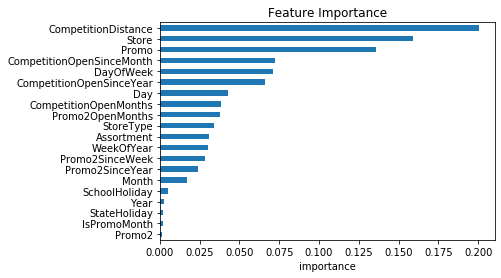

In [67]:
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

# Preprocessor Using Pipeline

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [29]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [30]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant', fill_value=0))
      ,('scaler', StandardScaler())
])


In [31]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
]) 


# Estimator

In [32]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestRegressor())
           ])

In [35]:
rf_model = pipeline.fit(X_train, y_train)
print (rf_model)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                          

# Model Accuracy

MSE is chosen as loss function because the dataset contains outliers that are important to the business

In [36]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
predictions = rf_model.predict(X_test)
print (f'r2_score : {r2_score(y_test, predictions)}\n\
RMSE:{np.sqrt(mean_squared_error(y_test, predictions))}\
 ')

r2_score : 0.9067938429778563
RMSE:798.2689954036797 


# Feature Importance

In [57]:
rf_model.steps[1][1].feature_importances_


array([0.1577928 , 0.04638751, 0.54124672, 0.13206146, 0.00538943,
       0.0106833 , 0.01273608, 0.01301683, 0.00942466, 0.0052261 ,
       0.03068109, 0.03535402])